# BERT

### Imports

In [1]:
import os
import numpy as np
import pandas as pd
import codecs
import tensorflow as tf
from tqdm import tqdm
from chardet import detect
import keras
from keras_radam import RAdam
from keras import backend as K
from keras_bert import load_trained_model_from_checkpoint
import codecs
from keras_bert import Tokenizer

Using TensorFlow backend.


### Parameters

In [2]:
SEQ_LEN = 128
BATCH_SIZE = 50
EPOCHS = 7
LR = 1e-4

#### Path to the pre trained model of BERT.

Download from [here](https://github.com/google-research/bert).

In [3]:
pretrained_path = 'uncased_L-12_H-768_A-12'
config_path = os.path.join(pretrained_path, 'bert_config.json')
checkpoint_path = os.path.join(pretrained_path, 'bert_model.ckpt')
vocab_path = os.path.join(pretrained_path, 'vocab.txt')

#### Loading Pretrained BERT model.

In [4]:
model = load_trained_model_from_checkpoint(
      config_path,
      checkpoint_path,
      training=True,
      trainable=True,
      seq_len=SEQ_LEN,
  )

In [5]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        (None, 128)          0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      (None, 128)          0                                            
__________________________________________________________________________________________________
Embedding-Token (TokenEmbedding [(None, 128, 768), ( 23440896    Input-Token[0][0]                
__________________________________________________________________________________________________
Embedding-Segment (Embedding)   (None, 128, 768)     1536        Input-Segment[0][0]              
____________________________________________________________________________________________

#### Extracting token dictionary from vocab of pretrained model to refer for input we will be using.


In [6]:
token_dict = {}
with codecs.open(vocab_path, 'r', 'utf8') as reader:
    for line in reader:
        token = line.strip()
        token_dict[token] = len(token_dict)

### Loading dataset


In [7]:
df1 = pd.read_json("./data/Sarcasm_Headlines_Dataset.json", lines=True)
df2 = pd.read_json("./data/Sarcasm_Headlines_Dataset_v2.json", lines=True)
# re-order attibute columns in df2
df2 = df2[['article_link','headline','is_sarcastic']]
df = pd.concat([df1, df2], axis=0)
df = df.drop(['article_link'], axis=1)
print(len(df))
df.head()

55328


,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


Reset the index as we have merged two different indexes.

In [8]:
df.reset_index(inplace=True, drop=True)

Drop duplicates

In [9]:
df.sort_values("headline", inplace = True)
df.drop_duplicates(subset ="headline", 
                     keep = 'first', inplace = True) 
print(len(df))

28503


#### Defining Tokenizer.


In [10]:
tokenizer = Tokenizer(token_dict)

#### Splitting data into train, test preceded by tokenizing sentences and returning test train data.


In [21]:
df.index

Int64Index([ 5891, 18992,  2387, 29853, 28486, 27419, 20083, 33972, 43953,
            26278,
            ...
            53825, 37989, 46481, 38548,  5184,  6848,  1973, 54774, 30747,
            52181],
           dtype='int64', length=28503)

In [27]:
len(df.index)

28503

In [51]:
def load_data():
    global tokenizer
    indices, sarc_labels = [], []
    for i in df.index:
        text = df.headline[i]
        ids, segments = tokenizer.encode(text, max_len=25)
        indices.append(ids)
        sarc_label = df.is_sarcastic[i]
        sarc_labels.append(sarc_label)
    items = list(zip(indices, sarc_labels))

    np.random.shuffle(items)
    test_items = items[int(0.8*len(items)):]
    train_items = items[:int(0.8*len(items))]
    indices_test, sarc_labels_test = zip(*test_items)
    indices_train, sarc_labels_train = zip(*train_items)
    indices_train = np.array(indices_train)
    indices_test = np.array(indices_test)
    mod_train = indices_train.shape[0] % BATCH_SIZE
    mod_test = indices_test.shape[0] % BATCH_SIZE
    if mod_train > 0:
        indices_train, sarc_labels_train = indices_train[:-mod_train], sarc_labels_train[:-mod_train]
    if mod_test > 0:
        indices_test, sarc_labels_test = indices_test[:-mod_test], sarc_labels_test[:-mod_test]

    return [indices_train, np.zeros_like(indices_train)], np.array(sarc_labels_train),[indices_test, np.zeros_like(indices_test)], np.array(sarc_labels_test)
  
train_x, train_y, test_x, test_y = load_data()

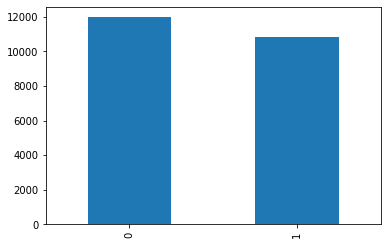

In [62]:
pd.Series(train_y).value_counts().plot(kind = 'bar')



#### Extracting layer from pretrained bert model and adding a layer with sigmoid function to classify a binary class.


In [ ]:
inputs = model.inputs[:2]
dense = model.get_layer('NSP-Dense').output
outputs = keras.layers.Dense(units=1, activation='sigmoid')(dense)

model = keras.models.Model(inputs, outputs)
model.compile(
  RAdam(learning_rate =LR),
  loss='sparse_categorical_crossentropy',
  metrics=['sparse_categorical_accuracy'],
)